# Using XGBoost to predict stock return

All the used files (hsiFactorDf, hsiReturnDf) in this script are generated from another jupyter notebook named Get Price and Volume Data then Calculate Simple Factors. The raw universe is scraped from Hang Seng official website from the jupyter notebook named Scrape HSI Constituents. 

Below codes are a brief example of utilizing XGBoost to predict stock return. 

XGBoost stands for eXtreme Gradient Boosting. 

XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions.

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Comparing with traditional quantitative linear model, some machine learning models like XGBoost could capture non-linear relationship. 

In fact, numerous factors displayed non-linear relationship with forward return. 

Please feel free to refer to this website to learn more about XGBoost. (<a href="https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/">Introduction to XGBoost</a>)

I won't talk about the details of XGBoost algorithm, but several points should be noted when using XGBoost to predict stock return.

## Why Boosting?

Three common Ensemble Methods in Machine Learning are Bagging, Boosting and Stacking.(<a href="https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205">Ensemble Methods Link 1</a>) (<a href="https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de">Ensemble Methods Link 2</a>)

Bagging means Bootstrap AGGregatING. It considers homogeneous weak learners, learns them independently in parallel and combines them following some kind of deterministic averaging process. Random Forest is an example.

Boosting considers homogeneous weak learners, but it learns them sequentially in a very adaptative way (a base model depends on the previous ones) and combines them following a deterministic strategy. Gradient Boosting is an example.

Stacking considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model to output a prediction based on the different weak models predictions. Combining various machine learning models to produce a meta-model is an example.

In summary, Boosting is the only sequential method among these three. Stacking is more like an optimization step to combine multiple machine learning models and produce the best meta model. Bagging is a classical method, but it's result will be affected by randomness of subset creation and effectiveness of the average process.

As stock factors did present some linkage among each other and we don't want to be affected much by the randomness of the model, a more consistent model will be preferred and that's why Boosting instead of Bagging.

## Why XGBoost?

Among the popular algorithms in Boosting, I believe XGBoost is the most sophisticated one currently. It overcame the speed problem in traditional boosting algorithms and also boosted it's performance.

One of the example is the improvement in deciding the next split.

When XGBoost need to decide the next split in it's tree, it will run the possible trees parallelly to the root and then pick the best route with the best overall score for the whole tree, while traditional boosting algorithm will only pick the best split for the next level.

For example, assuming the first level of the tree is PE which has a score of +5, the second level is PB +2 and PS +4, and the third level is PS after PB +2, DY after PB +8, PB after PS +1, DY after PS -1. In traditional boosting, it will pick PE(+5)->PS(+4)->PB(+1), the tree with the best score in each stage with an overall score +10. In XGBoost, it will pick PE(+5)->PB(+2)->DY(+8), the tree with the best overall score +15.

Besides, the parallelization of tree and some other optimization techniques did improve the execution speed comparing with traditional boosting algorithms.

## Sample Codes

Below code is an example to predict monthly return by the same month in the past several years to see whether seasonality is presented in Hang Seng Index (HSI).

Actually, it's just a simple case to use XGBoost to predict stock return. 

Various compositions could be used with XGBoost to predict stock return, like a short term model to predict next month stock return by previous month or a medium term model to predict next month stock return by previous 12 months, etc.

Feature Engineering is important. In our case, we just use below features created from price and volume data. Of course, it's not a comprehensive solution. We should have more dimensions in our features, like including value, growth, size, or other style factors.

{'126D Daily Return Skewness',
 '21D Daily Return High',
 '21D Daily Return Low',
 '21D Daily Return Skewness',
 '21D Daily Return Volatility',
 '21D Price EMA To 63D Price EMA',
 '21D Total Return',
 '252D Daily Return Skewness',
 '252D Total Return',
 '252D-21D Total Return',
 '50D Price EMA To 200D Price EMA',
 '63D Daily Return Skewness',
 '63D Daily Return Volatility',
 'Price To 252D Daily Price High',
 'Price To 252D Daily Price Low'}

Label is a another area we could improve to get a better model. I just use total absolute return in the sample codes. However, it could be relative return or return adjusted for volatility.

Apart from Feature Engineering and Label Engineering, tuning parameters is also important. However, the best tuned model may not be the best performing model out of sample. (<a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/">Complete Guide to Parameter Tuning in XGBoost</a>)

Something to bear in mind as financial data is very dynamic. It's doesn't like detecting disease from X-Ray. The best model in the sample may not be the best model out of sample. That's why Feature Engineering and Label Engineering are important.

Anyway, let's start with constructing our dataframes first.

In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

### Raw Files

In [2]:
hsiFactorDf = pd.read_csv('hsiFactorDf.csv', low_memory=False)
hsiReturnDf = pd.read_csv('hsiReturnDf.csv', low_memory=False)

for df in ['hsiFactorDf', 'hsiReturnDf']:
    for column in globals()[df].columns:
        if 'Date' in column:
            globals()[df][column] = globals()[df][column].astype('datetime64[ns]')

In [3]:
hsiFactorDf.head()

,Stock Code,Update Date,Factor Value,Factor Name
0,0001.HK,2019-09-30,-21.552123,252D Total Return
1,0002.HK,2019-09-30,-10.148627,252D Total Return
2,0003.HK,2019-09-30,8.770902,252D Total Return
3,0005.HK,2019-09-30,-5.408284,252D Total Return
4,0006.HK,2019-09-30,-0.931519,252D Total Return


In [4]:
hsiReturnDf.head()

,Update Date,Stock Code,Return
0,2007-10-03,0001.HK,-0.050000
1,2007-10-03,0002.HK,-0.017723
2,2007-10-03,0003.HK,0.088397
3,2007-10-03,0004.HK,-0.042672
4,2007-10-03,0005.HK,0.024983


### Get Machine Learning DataFrame

In [5]:
def getMLDataDf(hsiFactorDf, hsiReturnDf):
    factorList = list(set(hsiFactorDf['Factor Name']))
    mlDataDf = hsiFactorDf[['Stock Code', 'Update Date']].drop_duplicates()
   
    for factor in factorList:
        thisFactorDf = hsiFactorDf[hsiFactorDf['Factor Name'] == factor].copy()
        thisFactorDf = thisFactorDf.rename(columns={'Factor Value': factor})
        thisFactorDf = thisFactorDf.drop(columns='Factor Name')
        mlDataDf = pd.merge(mlDataDf, thisFactorDf, on=['Stock Code', 'Update Date'], how='left')
   
    updateDateList = list(mlDataDf['Update Date'].drop_duplicates())
    returnLastDate = hsiReturnDf['Update Date'].max()
   
    forwardReturnDfList = []
    for date in updateDateList:
        thisStartDate = date + relativedelta(months=1) + relativedelta(day=1)
        thisEndDate = date + relativedelta(months=1) + relativedelta(day=31)
        
        if thisEndDate <= returnLastDate:
            thisStockList = list(mlDataDf[mlDataDf['Update Date'] == date]['Stock Code'])

            # Enter the trade at close on the day after Update Date
            # And Exit on the last trading day in the coming month
            thisReturnDf = hsiReturnDf[(hsiReturnDf['Stock Code'].isin(thisStockList)) &
                                       (hsiReturnDf['Update Date'] > thisStartDate) &
                                       (hsiReturnDf['Update Date'] <= thisEndDate)].copy()
            thisReturnDf = pd.pivot_table(thisReturnDf, index='Update Date',
                                          columns='Stock Code', values='Return')
            thisReturnDf.iloc[0,:] = 0
            thisReturnDf = ((1 + thisReturnDf).prod() - 1) * 100
            thisReturnDf = thisReturnDf.reset_index().rename(columns={0: 'Forward Return'})
            thisReturnDf['Update Date'] = date
            forwardReturnDfList.append(thisReturnDf)
           
    forwardReturnDf = pd.concat(forwardReturnDfList)
    mlDataDf = pd.merge(mlDataDf, forwardReturnDf, on=['Stock Code', 'Update Date'])
    return mlDataDf, factorList

In [6]:
mlDataDf, factorList = getMLDataDf(hsiFactorDf=hsiFactorDf, hsiReturnDf=hsiReturnDf)

In [7]:
mlDataDf.head()

,Stock Code,Update Date,63D Daily Return Skewness,63D Daily Return Volatility,50D Price EMA To 200D Price EMA,21D Price EMA To 63D Price EMA,126D Daily Return Skewness,21D Daily Return Low,252D Total Return,21D Daily Return Skewness,Price To 252D Daily Price High,21D Total Return,Price To 252D Daily Price Low,252D-21D Total Return,21D Daily Return Volatility,21D Daily Return High,252D Daily Return Skewness,Forward Return
0,0001.HK,2019-08-30,0.332562,1.165519,0.938562,1.141039,0.274044,-2.584931,-20.661494,0.383419,0.816291,-5.793102,1.049155,-14.868392,1.592789,3.019135,0.323765,3.360717
1,0002.HK,2019-08-30,0.942943,1.148715,0.976337,1.095160,0.104580,-2.110973,-8.177963,1.210732,0.850523,-4.944081,1.015085,-3.233882,1.498476,3.582654,-0.123850,5.038261
2,0003.HK,2019-08-30,-1.305138,1.402568,1.034460,1.187526,-1.184026,-5.263159,7.445793,-0.598366,0.845810,-12.485542,1.042973,19.931335,2.078311,1.805043,-1.252383,3.346327
3,0005.HK,2019-08-30,0.393721,0.800550,0.956802,1.160173,0.218022,-2.286196,-14.776642,0.781741,0.828488,-9.485710,1.004460,-5.290932,1.135320,2.566377,-0.087607,7.760929
4,0006.HK,2019-08-30,-0.176952,1.015426,1.012573,0.924577,-0.394174,-2.338634,-2.078932,-0.445133,0.907616,-3.884970,1.049762,1.806038,1.212396,1.596241,-0.370025,2.133855


# Using XGBoost to Predict Return

After getting all the usable data from above codes. Below codes are the core of this script.

Our objective is to use XGBoost to predict seasonality.

Framework

1. Define outperformer and underperformer based on labelThreshold (30) and labelColumn (Forward Return)


2. Define XGBoost parameters and set a seed. [learning rate (0.05), number of estimators (1000), max depth (8), objective (binary:logistic), seed(628), others (default)]. I also set silent as 0 to avoid getting output when XGBoost is running. It's optional.


3. Optimize number of estimators based on number of boosting round (5000), nfold (2), early stop rounds (50), metrics (auc)


4. Set yearLength (7) and start looping through the Update Date in our adjMLDataDf


5. If there have 7 years record for the same month, the model will use it as training sample to predict the next coming month return. For example, using last factors as training X and forward return (October's return) as training Y in each September between 2009 and 2015 to construct a XGBoost model, then use this model to derive probabilities for the stocks' forward return label (2016 October's return) (testing Y) based on the last factors in 2016 September (testing X).


6. Construct an equal weighted long short portfolio based on the outperformers and underperformers that we got from XGBoost Model.

Several points should be noted before reading the codes. 

1. Number of years is important to define the size of our testing sample. I use 7 years as rolling testing sample. (using the same months in the past 7 years to predict this month return). Unfortunately, I didn't scrape much data for this demonstration. After all, we should have 3 years data to review the result.


2. XGBoost is sensitive to noises and financial data is super noisy. I will use XGBoost as a Classifier instead of Regressor. In order to better classify the label, I will apply a threshold on it. I will use 30 in this case. (rank return by percentile, less than 30 percentile will be 1 [outperformer], less than 70 percentile will be 0 [underperformer]).


3. labelThreshold is not applicable in testing label only, but also the final process to define outperformer and underperformer based on the probabilities generated from the XGBoost. As I have set 30 in labelThreshold, only win probability rank lower than 30 percentile will be considered as outperformer and only loss probability rank lower than 30 percentile will be considered as underperformer (higher probability with higher rank). As a result, if the criteria is too strict, there may have no stocks to be classified as outperformer or underperformer. 


4. XGBoost has multiple parameters could be optimized. I just optimize the Number of Estimators with the XGBoost default cv function in our simple example. You could optimize other parameters following this guide with the GridSearchCV function from sklearn. (<a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/">Complete Guide to Parameter Tuning in XGBoost</a>)

In [8]:
labelColumn = 'Forward Return'
labelThreshold = 30

In [9]:
factorList

['63D Daily Return Skewness',
 '63D Daily Return Volatility',
 '50D Price EMA To 200D Price EMA',
 '21D Price EMA To 63D Price EMA',
 '126D Daily Return Skewness',
 '21D Daily Return Low',
 '252D Total Return',
 '21D Daily Return Skewness',
 'Price To 252D Daily Price High',
 '21D Total Return',
 'Price To 252D Daily Price Low',
 '252D-21D Total Return',
 '21D Daily Return Volatility',
 '21D Daily Return High',
 '252D Daily Return Skewness']

In [17]:
def getLabel(mlDataDf, labelColumn, labelThreshold):
    adjMLDataDf = mlDataDf.copy()
    if labelThreshold >= 1 and labelThreshold <= 50:
        upperBand = labelThreshold / 100
        lowerBand = (100 - labelThreshold) / 100
    else:
        raise Exception('labelThreshold must be between 1 and 50')
        
    adjMLDataDf['Label Rank'] = adjMLDataDf.groupby('Update Date')[labelColumn].rank(pct=True, ascending=False)
    adjMLDataDf['Label'] = [1 if rank <= upperBand else -1 if rank >= lowerBand else 0 
                            for rank in adjMLDataDf['Label Rank']]
    return adjMLDataDf

In [18]:
adjMLDataDf = getLabel(mlDataDf=mlDataDf, labelColumn=labelColumn, labelThreshold=labelThreshold)

In [66]:
adjMLDataDf.head()

,Stock Code,Update Date,63D Daily Return Skewness,63D Daily Return Volatility,50D Price EMA To 200D Price EMA,21D Price EMA To 63D Price EMA,126D Daily Return Skewness,21D Daily Return Low,252D Total Return,21D Daily Return Skewness,Price To 252D Daily Price High,21D Total Return,Price To 252D Daily Price Low,252D-21D Total Return,21D Daily Return Volatility,21D Daily Return High,252D Daily Return Skewness,Forward Return,Label Rank,Label
0,0001.HK,2019-08-30,0.332562,1.165519,0.938562,1.141039,0.274044,-2.584931,-20.661494,0.383419,0.816291,-5.793102,1.049155,-14.868392,1.592789,3.019135,0.323765,3.360717,0.38,0
1,0002.HK,2019-08-30,0.942943,1.148715,0.976337,1.095160,0.104580,-2.110973,-8.177963,1.210732,0.850523,-4.944081,1.015085,-3.233882,1.498476,3.582654,-0.123850,5.038261,0.28,1
2,0003.HK,2019-08-30,-1.305138,1.402568,1.034460,1.187526,-1.184026,-5.263159,7.445793,-0.598366,0.845810,-12.485542,1.042973,19.931335,2.078311,1.805043,-1.252383,3.346327,0.40,0
3,0005.HK,2019-08-30,0.393721,0.800550,0.956802,1.160173,0.218022,-2.286196,-14.776642,0.781741,0.828488,-9.485710,1.004460,-5.290932,1.135320,2.566377,-0.087607,7.760929,0.10,1
4,0006.HK,2019-08-30,-0.176952,1.015426,1.012573,0.924577,-0.394174,-2.338634,-2.078932,-0.445133,0.907616,-3.884970,1.049762,1.806038,1.212396,1.596241,-0.370025,2.133855,0.54,0


In [51]:
xgbParams = {'learning_rate': 0.05, 
             'n_estimators': 1000,
             'max_depth': 8,
             'objective': 'binary:logistic',
             'seed': 628,
             'silent': 0}
cvOptimize = False
numBoostRound = 5000
nFold = 2
earlyStopRound = 50

In [52]:
def getCVOptimizeNEstimators(xgbModel, thisTrainX, thisTrainY, numBoostRound, nFold, earlyStopRound):
    modelParams = xgbModel.get_xgb_params()
    xgbTrain = xgb.DMatrix(thisTrainX.values, label=thisTrainY.values)
    cvResult = xgb.cv(modelParams, xgbTrain, num_boost_round=numBoostRound, nfold=nFold, metrics=['auc'], early_stopping_rounds=earlyStopRound,
                      stratified=True, shuffle=True)
    del modelParams, xgbTrain
    return cvResult.shape[0]

def runXGBoostModel(thisTrainDf, thisTestDf, factorList, labelThreshold, xgbParams, cvOptimize, numBoostRound=None, nFold=None, earlyStopRound=None):
    thisTrainX = thisTrainDf[factorList].copy()
    thisTrainY = thisTrainDf['Label'].replace({-1:0})

    thisTestX = thisTestDf[factorList].copy()

    xgbModel = xgb.XGBClassifier(**xgbParams)

    if cvOptimize == True:
        cvEstimator = getCVOptimizeNEstimators(xgbModel=xgbModel, thisTrainX=thisTrainX, thisTrainY=thisTrainY,
                                               numBoostRound=numBoostRound, nFold=nFold, earlyStopRound=earlyStopRound)
        xgbModel = xgbModel.set_params(n_estimators=cvEstimator)
        del cvEstimator

    thisModel = xgbModel.fit(thisTrainX, thisTrainY, verbose=True)
    thisTestY = thisModel.predict_proba(thisTestX)
    thisTestY = pd.DataFrame(thisTestY)
    thisTestY.columns = thisModel.classes_

    thisTradeDf = thisTestDf[['Stock Code', 'Update Date']].copy().reset_index().drop(columns='index')
    thisTradeDf = pd.concat([thisTradeDf, pd.DataFrame(thisTestY)], axis=1).rename(columns={0: 'Loss Prob', 1: 'Win Prob'})

    thisTradeDf['Win Rank'] = thisTradeDf['Win Prob'].rank(pct=True, ascending=False)
    thisTradeDf['Loss Rank'] = thisTradeDf['Loss Prob'].rank(pct=True, ascending=False)

    thisWinTradeDf = thisTradeDf[thisTradeDf['Win Rank'] <= labelThreshold / 100].copy()
    thisWinTradeDf['Weight'] = 1 / len(thisWinTradeDf.index)
    
    thisLossTradeDf = thisTradeDf[thisTradeDf['Loss Rank'] <= labelThreshold / 100].copy()
    thisLossTradeDf['Weight'] = -1 / len(thisLossTradeDf.index)
    del thisTrainX, thisTrainY, thisTestDf, thisTestX, xgbModel, thisModel, thisTestY, thisTradeDf
    return thisWinTradeDf, thisLossTradeDf


In [53]:
def getSeasonModel(mlDataDf, labelThreshold, xgbParams, factorList, yearLength, 
                   cvOptimize, numBoostRound=None, nFold=None, earlyStopRound=None):
    seasonModelDfList = []
    dateList = sorted(list(mlDataDf['Update Date'].drop_duplicates()))
    lenOfDateList = len(dateList)
    for date in dateList:
        thisDatePos = dateList.index(date)
        if thisDatePos >= 12 * yearLength:
            thisTrainDateList = dateList[thisDatePos-12 * yearLength:thisDatePos:12]
            thisTrainDf = mlDataDf[(mlDataDf['Update Date'].isin(thisTrainDateList)) &
                                   ((mlDataDf['Label'] == 1) | (mlDataDf['Label'] == -1))].copy()
            thisTestDf = mlDataDf[mlDataDf['Update Date'] == pd.Timestamp(date)].copy()

            thisWinTradeDf, thisLossTradeDf = runXGBoostModel(thisTrainDf=thisTrainDf, thisTestDf=thisTestDf,
                                                              factorList=factorList, labelThreshold=labelThreshold,
                                                              xgbParams=xgbParams, cvOptimize=cvOptimize,
                                                              numBoostRound=numBoostRound, nFold=nFold, earlyStopRound=earlyStopRound)
            seasonModelDfList.append(thisWinTradeDf)
            seasonModelDfList.append(thisLossTradeDf)
            del thisTrainDateList, thisTrainDf, thisTestDf, thisWinTradeDf, thisLossTradeDf
            
    seasonModelDf = pd.concat(seasonModelDfList)
    del seasonModelDfList, dateList, lenOfDateList
    return seasonModelDf


In [54]:
seasonModelDf = getSeasonModel(mlDataDf=adjMLDataDf, labelThreshold=labelThreshold, xgbParams=xgbParams, 
               factorList=factorList, yearLength=7, 
               cvOptimize=False, numBoostRound=numBoostRound, nFold=nFold, earlyStopRound=earlyStopRound)

In [65]:
seasonModelDf.head()

,Stock Code,Update Date,Loss Prob,Win Prob,Win Rank,Loss Rank,Weight
2,0003.HK,2016-09-30,0.685734,0.314266,0.250000,0.770833,0.071429
3,0005.HK,2016-09-30,0.674355,0.325645,0.229167,0.791667,0.071429
11,0083.HK,2016-09-30,0.402149,0.597851,0.145833,0.875000,0.071429
13,0151.HK,2016-09-30,0.034598,0.965402,0.020833,1.000000,0.071429
14,0267.HK,2016-09-30,0.326608,0.673392,0.125000,0.895833,0.071429


# Simple Summary and Chart

Let's do some basic calculation to get a brief summary of the strategy after getting the model dataframe.

Overall, the result seems positive between 2016 September and 2019 September with 22% return and 1.44 Sharpe Ratio assuming risk free rate is 0. However, hit ratio is just slightly over 50%, which means the high return may mainly came from some very profitable trades. Besides, -13% maximun drawdown is quite huge. The strategy is suffering in 2018 when the market was turning down. 

Anyway, this test set is not large enough. It'd be better to test with longer period. 

Finally, I will generate a trade file which could be used in another jupyter notebook for performance evaluation.

In [148]:
modelDf = pd.merge(seasonModelDf, adjMLDataDf[['Stock Code', 'Update Date', 'Forward Return']], 
                   on=['Stock Code', 'Update Date'], how='left')
modelDf['Weighted Return'] = modelDf['Weight'] * modelDf['Forward Return']
modelDf['hit'] = [1 if (forwardReturn > 0 and weight > 0) or 
                  (forwardReturn < 0 and weight < 0) else 0 for forwardReturn, weight 
                  in np.array(modelDf[['Forward Return', 'Weight']])]

modelReturnDf = pd.DataFrame(bTestDf.groupby('Update Date')['Weighted Return'].sum()).rename(columns={'Weighted Return': 'Monthly Return'}).reset_index()
modelReturnDf['Return'] = ((1 + modelReturnDf['Monthly Return']/100).cumprod() - 1) * 100

# Trade End Date should be the Next Month End after Update Date
modelReturnDf['Update Date'] = [date + relativedelta(months=1) + relativedelta(day=31) for date in modelReturnDf['Update Date']]
modelReturnDf['Rolling Max Return'] = modelReturnDf['Return'].cummax()
modelReturnDf['Return Drawdown'] = modelReturnDf['Return'] - modelReturnDf['Rolling Max Return']
modelReturnDf = modelReturnDf.set_index('Update Date')

In [149]:
print('Start Date: ' + modelDf['Update Date'].min().strftime('%d/%m/%Y'))
print('End Date: ' + modelReturnDf.index[-1].strftime('%d/%m/%Y'))
print('Return: ' + '{:,.2f}%'.format(modelReturnDf['Return'][-1]))
print('Hit Ratio: ' + '{:,.2f}%'.format(modelDf['hit'].sum() / modelDf['hit'].count() * 100))
print('Max Return Drawdown: ' + '{:,.2f}%'.format(modelReturnDf['Return Drawdown'].min()))
print('Sharpe Ratio: ' + '{:,.2f}'.format(modelReturnDf['Return'][-1] / 
                                          (modelReturnDf['Monthly Return'].std() * 
                                           (len(modelReturnDf.index) ** 0.5))))

Start Date: 30/09/2016
End Date: 30/09/2019
Return: 22.01%
Hit Ratio: 51.66%
Max Return Drawdown: -13.30%
Sharpe Ratio: 1.44


Text(0, 0.5, 'Return Drawdown')

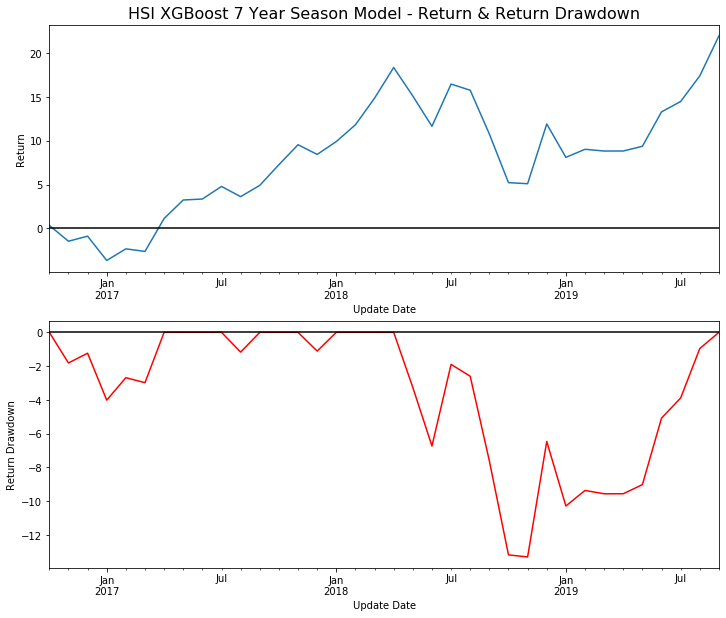

In [172]:
plt.subplot(2,1,1)
modelReturnDf['Return'].plot(figsize=(12,10))
plt.axhline(y=0, color='k')
plt.ylabel('Return')
plt.title('HSI XGBoost 7 Year Season Model - Return & Return Drawdown', fontsize=16)
plt.subplot(2,1,2)
modelReturnDf['Return Drawdown'].plot(figsize=(12,10), color='r')
plt.axhline(y=0, color='k')
plt.ylabel('Return Drawdown')

In [135]:
tradeFileDf = modelDf[['Stock Code', 'Update Date', 'Weight']].copy()
tradeFileDf['Trade Start Date'] = [date + relativedelta(months=1) + relativedelta(day=1) 
                                   for date in tradeFileDf['Update Date']]
tradeFileDf['Trade End Date'] = [date + relativedelta(months=1) + relativedelta(day=31) 
                                 for date in tradeFileDf['Update Date']]

In [136]:
tradeFileDf.head()

,Stock Code,Update Date,Weight,Trade Start Date,Trade End Date
0,0003.HK,2016-09-30,0.071429,2016-10-01,2016-10-31
1,0005.HK,2016-09-30,0.071429,2016-10-01,2016-10-31
2,0083.HK,2016-09-30,0.071429,2016-10-01,2016-10-31
3,0151.HK,2016-09-30,0.071429,2016-10-01,2016-10-31
4,0267.HK,2016-09-30,0.071429,2016-10-01,2016-10-31


In [137]:
tradeFileDf.to_csv('hsiSeasonModel7.csv', index=False)